# Kaggle Titanic Classification

Here is a first pass at the Kaggle Titanic challenge to predict which passengers will survive. This is in no way final, but a quick implementation of a logistic regression.

Some resources:
- [Kaggle Titanic Page](https://www.kaggle.com/c/titanic/data#)
- [`sm.Logit`](http://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Logit.html)
- [Logistic Regression Example](http://blog.yhat.com/posts/logistic-regression-python-rodeo.html)

First, load the required libraries and examine their versions.

In [1]:
import pandas as pd
import numpy as np
import statsmodels
import statsmodels.api as sm

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 150
plt.style.use('seaborn-ticks')


/Users/matthewkudija/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%load_ext watermark
%watermark -iv

pandas      0.22.0
numpy       1.13.3
statsmodels  0.8.0
matplotlib  2.2.2



## Training the Model
Next load the training dataset and update categorical variables. Unlike the OLS regression, the `sm.Logit` doesn't seem to like non-integer/float values. 
- Sex: 0 for male, 1 for female
- Age: we do buckets decided to roughly represent physical capability
- Cabin: not sure what A vs. B vs. C is but assuming it is floor (maybe?) so grouping together
- Embarked: the city they came from, likely not important

In [3]:
df = pd.read_csv('data/train.csv')
df['Sex'] = np.where(df['Sex']=='male',0,1)
df['AgeCat'] = np.where(df.Age<18,0,
               np.where(df.Age<40,1,
               np.where(df.Age<60,2,
               np.where(df.Age<80,3,
                        4
                    ))))
df['CabinCat'] = np.where(df.Cabin.str[0]=='A',0,
                 np.where(df.Cabin.str[0]=='B',1,
                 np.where(df.Cabin.str[0]=='C',2,
                 np.where(df.Cabin.str[0]=='D',3,
                 np.where(df.Cabin.str[0]=='E',4,
                 np.where(df.Cabin.str[0]=='F',5,
                 np.where(df.Cabin.str[0]=='G',6,
                 np.where(df.Cabin.str[0]=='T',7,
                          8                         
                         ))))))))
df['EmbarkedCat'] = np.where(df.Embarked=='S',0,
                    np.where(df.Embarked=='C',1,
                    np.where(df.Embarked=='Q',2,
                             3
                    )))
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeCat,CabinCat,EmbarkedCat
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,1,8,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,1,2,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,8,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,1,2,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,1,8,0


In [4]:
pd.crosstab(df['Survived'], df['Pclass'], rownames=['Survived'])

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


Here we will use Statsmodels to perform the logistic regression. We fit the model, view the summary output, and then use the model to generate predictions with our training data to see how well we did.

In [5]:
logit = sm.Logit(df['Survived'], df[['Pclass','Sex','SibSp','Parch','Fare',
                                     'AgeCat','CabinCat','EmbarkedCat']])

result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.452148
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      883
Method:                           MLE   Df Model:                            7
Date:                Mon, 28 May 2018   Pseudo R-squ.:                  0.3210
Time:                        21:40:10   Log-Likelihood:                -402.86
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 2.927e-78
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Pclass         -0.5559      0.151     -3.684      0.000      -0.852      -0.260
Sex             2.7102      0.194     13.961      0.000       2.330       3.091
SibSp          -0.2680      0.104     -2.574      0.010      -0.472      -0.064
Parch          -0.1393      0.116     -1.202      0.229      -0.366       0.088
Fare            0.0067      0.002      2.965      0.003       0.002       0.011
AgeCat         -0.2058      0.071     -2.893      0.004      -0.345      -0.066
CabinCat       -0.0205      0.049     -0.414      0.679      -0.117       0.076
EmbarkedCat     0.3548      0.147      2.420      0.016       0.067       0.642
===============================================================================
"""

In [6]:
df['Predicted'] = result.predict(df[['Pclass','Sex','SibSp','Parch','Fare',
                                     'AgeCat','CabinCat','EmbarkedCat']])

In [7]:
# df.to_csv('predicted.csv')

In [8]:
df[['Survived','Predicted']].sort_values('Predicted',ascending=False).head()

,Survived,Predicted
258,1,0.996115
716,1,0.977589
299,1,0.972982
61,1,0.971378
700,1,0.970902


Since the model predictions are floats between 0 and 1 (not binary 0 **OR** 1), we need to choose a threshold. Values above the threshold are 1 (survived) and below the threshold are 0 (died). We perform a quick sweep to see the accuracy of the predictions at different threshold levels.

In [9]:
thresh = np.arange(0,1,.05)
accuracies = []
for i in range(len(thresh)):
    df['PredictedBinary'] = np.where(df['Predicted']>thresh[i],1,0)
    df['Accuracy'] = np.where(df['Survived']==df['PredictedBinary'],True,False)
    accuracy = df['Accuracy'].sum() / df.shape[0]
    accuracies.append(accuracy)

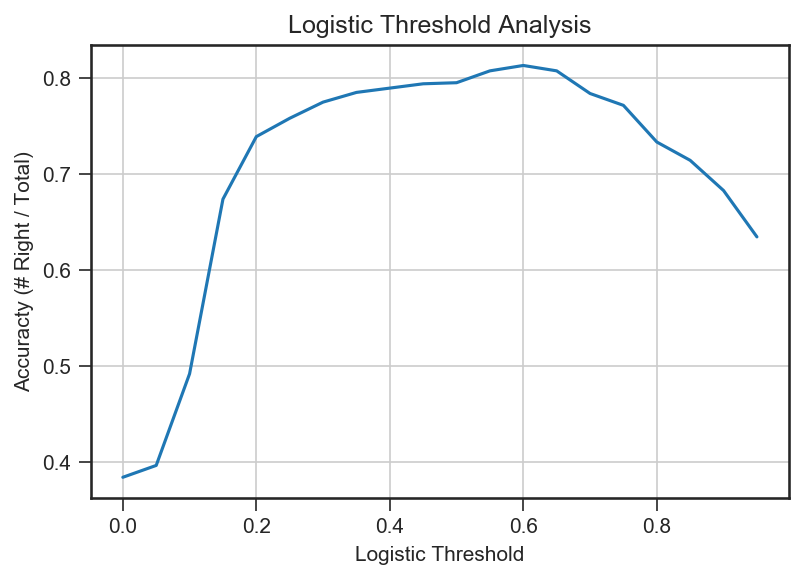

In [10]:
plt.plot(thresh,accuracies)
plt.xlabel('Logistic Threshold')
plt.ylabel('Accuracty (# Right / Total)')
plt.title('Logistic Threshold Analysis')
plt.grid()

It looks like the accuracy is highest with a threshold of **`0.6`**, so we will use that for the predictions on the test data.

## Predictions
Now we load the test dataset, categorize variables as before, and use our model to generate predictions.

In [11]:
dfTest = pd.read_csv('data/test.csv')
dfTest['Sex'] = np.where(dfTest['Sex']=='male',0,1)
dfTest['AgeCat'] = np.where(dfTest.Age<18,0,
               np.where(dfTest.Age<40,1,
               np.where(dfTest.Age<60,2,
               np.where(dfTest.Age<80,3,
                        4
                    ))))
dfTest['CabinCat'] = np.where(dfTest.Cabin.str[0]=='A',0,
                 np.where(dfTest.Cabin.str[0]=='B',1,
                 np.where(dfTest.Cabin.str[0]=='C',2,
                 np.where(dfTest.Cabin.str[0]=='D',3,
                 np.where(dfTest.Cabin.str[0]=='E',4,
                 np.where(dfTest.Cabin.str[0]=='F',5,
                 np.where(dfTest.Cabin.str[0]=='G',6,
                 np.where(dfTest.Cabin.str[0]=='T',7,
                          8                         
                         ))))))))
dfTest['EmbarkedCat'] = np.where(dfTest.Embarked=='S',0,
                    np.where(dfTest.Embarked=='C',1,
                    np.where(dfTest.Embarked=='Q',2,
                             3
                    )))
dfTest.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeCat,CabinCat,EmbarkedCat
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,Q,1,8,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,S,2,8,0
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,Q,3,8,2
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,S,1,8,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,S,1,8,0


In [12]:
dfTest['Predicted'] = result.predict(dfTest[['Pclass','Sex','SibSp','Parch','Fare',
                                     'AgeCat','CabinCat','EmbarkedCat']])
thresh=0.6
dfTest['Survived'] = np.where(dfTest['Predicted']>thresh,1,0)
dfTest[['PassengerId','Survived']].head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [13]:
dfTest = dfTest[['PassengerId','Survived']]
dfTest.to_csv('Predictions-submit.csv',index=False)